# Finetune CellVIT-SAM model decoders with a pre-trained SAM encoder

This example shows how to use `cellseg_models.pytorch` for training a [CellVIT-SAM](https://arxiv.org/abs/2306.15350) model for instance segmentation. We will be using hugginfaces [accelerate](https://huggingface.co/docs/accelerate/index) library to train the model.

In [1]:
import torch
import accelerate
import cellseg_models_pytorch
from platform import python_version

print("torch version:", torch.__version__)
print("accelerate version:", accelerate.__version__)
print("cellseg_models_pytorch version:", cellseg_models_pytorch.__version__)
print("python version:", python_version())

torch version: 2.1.1+cu121
accelerate version: 0.31.0
cellseg_models_pytorch version: 0.1.25
python version: 3.10.12


First, we will download some nuclei segmentation data. We will use the [Pannuke](https://jgamper.github.io/PanNukeDataset/) dataset by Gamper et al. The Pannuke dataset is split into three folds. We will use the first and second fold as training data and the third as validation data.

Since we will finetune the [CellVit-SAM](ttps://arxiv.org/abs/2306.15350) model decoders, we need to define the right nuclei instance transformations for training time. The CellVIT-SAM models regresses the same auxilliary output as the `HoVer-Net`-model, thus, we define `"hovernet"` transformation here as well. The `"hovernet"` transforms the labelled instance masks into horizontal and vertical image gradients of the nuclei. The model has an output head that regresses these types of masks which will be used for post-processing the nuclei.

Besides the instance mask transformations, we will also set `"blur"` and `"hue_sat"` (hue saturation) transformations and `"minmax"` normalization for the input images.

In [2]:
from pathlib import Path
from cellseg_models_pytorch.datamodules import PannukeDataModule

fold_split = {"fold1": "train", "fold2": "train", "fold3": "valid"}

# NOTE The 'pannuke' directory has to already exist for this to work.
# You can create one in your home folder or just modify the path to your liking,
# The pannuke dataset will be downloaded there.
save_dir = Path.home() / "pannuke_dataset"
pannuke_module = PannukeDataModule(
    save_dir=save_dir,
    fold_split=fold_split,
    inst_transforms=["hovernet"],
    img_transforms=["blur", "hue_sat"],
    normalization="minmax",
    batch_size=8,
    num_workers=8,
)

# NOTE: this will take a while to run
pannuke_module.prepare_data()  # download and process the pannuke data

Found all folds. Skip downloading.
Found processed pannuke data. If in need of a re-download, please empty the `save_dir` folder.


## Visualize training samples

Here we plot the training image patches with their corresponding instance and type label masks to get a glimpse of what kind of training data Pannuke has.

We also visualize the `hovernet` transformation applied to the instance masks. The `CellVIT-SAM`-model is going to regress this transformed auxilliary output which is later used in post-processing to separate overlapping and clumped nuclei.

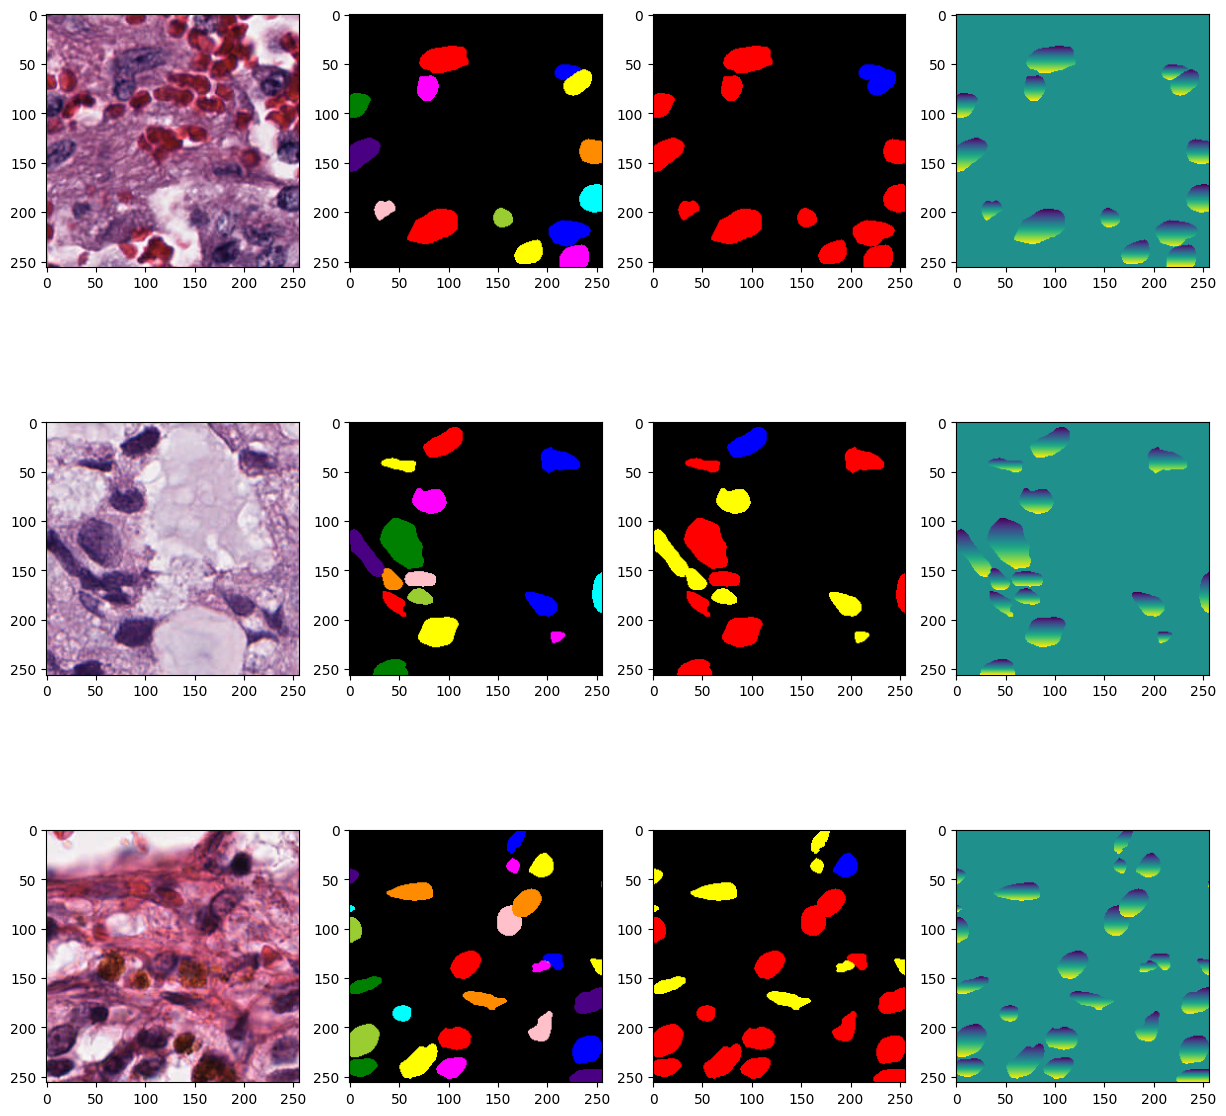

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb

# filehandler contains methods to read and write images and masks
from cellseg_models_pytorch.utils import FileHandler
from cellseg_models_pytorch.transforms.functional import gen_hv_maps

img_dir = save_dir / "train" / "images"
mask_dir = save_dir / "train" / "labels"
imgs = sorted(img_dir.glob("*"))
masks = sorted(mask_dir.glob("*"))

ixs = np.random.randint(0, 500, 3)

im1 = FileHandler.read_img(imgs[ixs[0]])
im2 = FileHandler.read_img(imgs[ixs[1]])
im3 = FileHandler.read_img(imgs[ixs[2]])
mask1 = FileHandler.read_mat(masks[ixs[0]], return_all=True)
mask2 = FileHandler.read_mat(masks[ixs[1]], return_all=True)
mask3 = FileHandler.read_mat(masks[ixs[2]], return_all=True)

fig, ax = plt.subplots(3, 4, figsize=(15, 15))
ax = ax.flatten()
ax[0].imshow(im1)
ax[1].imshow(label2rgb(mask1["inst_map"], bg_label=0))
ax[2].imshow(label2rgb(mask1["type_map"], bg_label=0))
ax[3].imshow(gen_hv_maps(mask1["inst_map"])[0])
ax[4].imshow(im2)
ax[5].imshow(label2rgb(mask2["inst_map"], bg_label=0))
ax[6].imshow(label2rgb(mask2["type_map"], bg_label=0))
ax[7].imshow(gen_hv_maps(mask2["inst_map"])[0])
ax[8].imshow(im3)
ax[9].imshow(label2rgb(mask3["inst_map"], bg_label=0))
ax[10].imshow(label2rgb(mask3["type_map"], bg_label=0))
ax[11].imshow(gen_hv_maps(mask3["inst_map"])[0])

# Prepare the model and train-loop

Next, we will define a a simple `train`-loop wrapper function to train the model. The training logic in the wrapper is built with the [`accelerate`](https://huggingface.co/docs/accelerate/index). It is a convenient way to build training scripts in different types of computing environments. Check out https://huggingface.co/docs/accelerate/index for more.

In the training and validation loops we will have to take into account that the `PannukeDataModule`'s `DataLoader` returns the the inputs and targets in a dictionary like this:
```
{
    "image": torch.Tensor(B, 3, H, W),
    "type": torch.Tensor(B, C, H, W)
    "inst": torch.Tensor(B, 2, H, W)
    "hovernet": torch.Tensor(B, 2, H, W)
}
```
We will access the `"image"` value in the training loop.
The rest of the masks will be handled automatically in the multi-task-loss function.

### **Training configuration**:

All of these are defined in the `train()`-wrapper function.

**The model**.
First, we will define the CellVIT-SAM nuclei segmentation model with the `SA-1B` pre-trained SAM-Image-encoder. Here, we use the smallest `sam_vit_b` weights. Larger encoders with pretrained weights can be also used (`sam_vit_l`, `sam_vit_h`) 

**Branch losses**.
For each output of the model, we define a joint-loss function. These losses are summed together during backprop to form a multi-task loss. For the `"hovernet"`branch output we set a joint-loss composed of SSIM-loss (Structural Similarity Index) and MSE-loss (Mean Squared Error) and for the `"type"` (cell type predictions) and `"inst"` (cell background/foreground predictions) outputs we will set a joint-loss composed of CE-loss (Cross Entropy) and DICE-loss for both. For the CE-losses, we will also be using [spectral decoupling](https://arxiv.org/abs/2011.09468).


**Logging metrics.**
For the nuclei type masks we will monitor Jaccard-index i.e. the mIoU metric during training. The metric is averaged over the class-specific mIoUs. For the hovernet regression branch, we will log the mse-metric. The metrics are from the `torchmetrics` library.

**Optimizer and scheduler.**
The optimizer used here is [AdamW](https://arxiv.org/abs/1711.05101). The learning rate is scheduled with the [CosineAnnealingLR](https://paperswithcode.com/paper/sgdr-stochastic-gradient-descent-with-warm) schedule. Initial lr is set to 0.0003. 

**Other hyperparams.**
We will train for 5 epochs (for demo purposes), so the training will probably not converge to the best possible result but anyways the model will learn something.

In [4]:
import accelerate
from accelerate.utils import set_seed

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics import JaccardIndex, MeanSquaredError
from tqdm import tqdm

from cellseg_models_pytorch.models.cellvit.cellvit import cellvit_sam_base
from cellseg_models_pytorch.losses import (
    SSIM,
    DiceLoss,
    CELoss,
    JointLoss,
    MultiTaskLoss,
)


# Quick wrapper for MSE loss to make it fit the JointLoss API
class MSELoss(nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()

    def forward(
        self, yhat: torch.Tensor, target: torch.Tensor, **kwargs
    ) -> torch.Tensor:
        return F.mse_loss(yhat, target, reduction="mean")


# quick train wrapper func
def train():
    set_seed(42)

    # we will train with mixed precision
    project_dir = Path.home() / "pannuke" / "cellvit_accelerate"
    accelerator = accelerate.Accelerator(
        mixed_precision="fp16", project_dir=project_dir
    )

    # set dataloaders
    pannuke_module.setup()
    train_loader = pannuke_module.train_dataloader()
    val_loader = pannuke_module.val_dataloader()

    # Define the model with the function API.
    model = cellvit_sam_base(
        enc_name="samvit_base_patch16", type_classes=len(pannuke_module.type_classes)
    )

    # The backbone is so big that we will freeze it and just finetune the decoders
    model.freeze_encoder()

    # Define the multi-task loss function
    branch_losses = {
        "hovernet": JointLoss([SSIM(), MSELoss()]),
        "type": JointLoss([CELoss(apply_sd=True), DiceLoss()]),
        "inst": JointLoss([CELoss(apply_sd=True), DiceLoss()]),
    }

    multitask_loss = MultiTaskLoss(branch_losses=branch_losses)

    n_epochs = 5  # number of epochs to train for

    # optimizer and lr scheduler
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.0003)
    lr_scheduler = CosineAnnealingLR(
        optimizer, T_max=1000, eta_min=0, last_epoch=-1, verbose=False
    )

    # training metrics
    type_cls_train_metric = JaccardIndex(
        task="multiclass",
        average="macro",
        num_classes=len(pannuke_module.type_classes),
    ).to(accelerator.device)

    cellpose_reg_train_metric = MeanSquaredError().to(accelerator.device)

    # validation metrics
    type_cls_val_metric = JaccardIndex(
        task="multiclass",
        average="macro",
        num_classes=len(pannuke_module.type_classes),
    ).to(accelerator.device)

    cellpose_reg_val_metric = MeanSquaredError().to(accelerator.device)

    # prepare the model, optimizer, and dataloaders for accelerate
    model, optimizer, train_loader, val_loader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_loader, val_loader, lr_scheduler
    )

    # metric values for plotting
    train_mious = []
    train_mses = []
    val_mious = []
    val_mses = []

    # training loop
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0

        with tqdm(train_loader, unit="batch") as loader:
            loader.set_description(f"Epoch: {epoch}")
            for batch in loader:
                # run forward pass and compute loss
                soft_masks = model(batch["image"])
                targets = {k: val for k, val in batch.items() if k != "image"}
                loss = multitask_loss(soft_masks, targets)

                # compute total loss for tracking
                total_loss += loss.detach().float()
                batch_miou = type_cls_train_metric(soft_masks["type"], targets["type"])
                batch_mse = cellpose_reg_train_metric(
                    soft_masks["hovernet"], targets["hovernet"]
                )

                # round metrics to 4 decimal places for progress bar logging
                batch_miou = round(batch_miou.item(), 4)
                batch_mse = round(batch_mse.item(), 4)
                batch_loss = round(loss.item(), 4)

                # log loss and metrics in progress bar
                s = f"batch loss: {batch_loss}, batch miou: {batch_miou}, batch mse: {batch_mse}"
                loader.set_postfix_str(s)

                # run backward pass
                accelerator.backward(loss)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

        # metric on all batches using custom accumulation
        miou = type_cls_train_metric.compute()
        mse = cellpose_reg_train_metric.compute()
        train_mious.append(miou)
        train_mses.append(mse)
        accelerator.print(
            f"total loss on all train data: {round(total_loss.item(), 4)}"
        )
        accelerator.print(f"type mIoU on all train data: {round(miou.item(), 4)}")
        accelerator.print(f"hovernet mse on all train data: {round(mse.item(), 4)}")

        # Reseting internal state such that metrics are ready for new data
        type_cls_train_metric.reset()
        cellpose_reg_train_metric.reset()

        # save model checkpoint
        accelerator.save_model(model, project_dir)

        # validation loop
        model.eval()
        with tqdm(val_loader, unit="batch") as loader:
            loader.set_description("Validation epoch")
            for batch in loader:
                with torch.no_grad():
                    soft_masks = model(batch["image"])
                    targets = {k: val for k, val in batch.items() if k != "image"}

                    loss = multitask_loss(soft_masks, targets)

                    # compute total loss for tracking
                    total_loss += loss.detach().float()
                    batch_miou = type_cls_val_metric(
                        soft_masks["type"], targets["type"]
                    )
                    batch_mse = cellpose_reg_val_metric(
                        soft_masks["hovernet"], targets["hovernet"]
                    )

                    # round metrics to 4 decimal places for progress bar logging
                    batch_miou = round(batch_miou.item(), 4)
                    batch_mse = round(batch_mse.item(), 4)
                    batch_loss = round(loss.item(), 4)

                    # log loss and metrics in progress bar
                    s = f"val loss: {batch_loss}, val batch miou: {batch_miou}, val batch mse: {batch_mse}"
                    loader.set_postfix_str(s)

        # metric on all batches using custom accumulation
        miou = type_cls_val_metric.compute()
        mse = cellpose_reg_val_metric.compute()
        val_mious.append(miou)
        val_mses.append(mse)
        accelerator.print(
            f"total val loss on all val data: {round(total_loss.item(), 4)}"
        )
        accelerator.print(f"val type mIoU on all val data: {round(miou.item(), 4)}")
        accelerator.print(f"val hovernet mse on all val data: {round(mse.item(), 4)}")

        # Reseting internal state such that metrics are ready for new data
        type_cls_val_metric.reset()
        cellpose_reg_val_metric.reset()

    fig, ax = type_cls_val_metric.plot(val_mious)
    plt.show()

Launching training on one GPU.
(512, 512, 256, 128) [{'module': 'blocks.0', 'num_chs': 768, 'reduction': 16}, {'module': 'blocks.1', 'num_chs': 768, 'reduction': 16}, {'module': 'blocks.2', 'num_chs': 768, 'reduction': 16}, {'module': 'blocks.3', 'num_chs': 768, 'reduction': 16}]


Epoch: 0: 100%|██████████| 648/648 [14:38<00:00,  1.36s/batch, batch loss: 0.7498, batch miou: 0.4501, batch mse: 0.0266]


total loss on all train data: 702.9982
type mIoU on all train data: 0.2504
hovernet mse on all train data: 0.0387


Validation epoch: 100%|██████████| 341/341 [04:06<00:00,  1.38batch/s, val loss: 0.9146, val batch miou: 0.366, val batch mse: 0.0452] 


total val loss on all val data: 1007.5377
val type mIoU on all val data: 0.2834
val hovernet mse on all val data: 0.0285


Epoch: 1: 100%|██████████| 648/648 [19:48<00:00,  1.83s/batch, batch loss: 0.489, batch miou: 0.4246, batch mse: 0.0156] 


total loss on all train data: 552.4341
type mIoU on all train data: 0.3154
hovernet mse on all train data: 0.0261


Validation epoch: 100%|██████████| 341/341 [04:29<00:00,  1.27batch/s, val loss: 0.797, val batch miou: 0.3326, val batch mse: 0.0379] 


total val loss on all val data: 843.267
val type mIoU on all val data: 0.3309
val hovernet mse on all val data: 0.0259


Epoch: 2: 100%|██████████| 648/648 [18:35<00:00,  1.72s/batch, batch loss: 1.1489, batch miou: 0.2212, batch mse: 0.0291]


total loss on all train data: 565.6679
type mIoU on all train data: 0.3275
hovernet mse on all train data: 0.0274


Validation epoch: 100%|██████████| 341/341 [04:27<00:00,  1.27batch/s, val loss: 0.867, val batch miou: 0.3219, val batch mse: 0.0326] 


total val loss on all val data: 881.5159
val type mIoU on all val data: 0.318
val hovernet mse on all val data: 0.0261


Epoch: 3: 100%|██████████| 648/648 [18:56<00:00,  1.75s/batch, batch loss: 0.7946, batch miou: 0.3657, batch mse: 0.0217]


total loss on all train data: 534.9741
type mIoU on all train data: 0.3629
hovernet mse on all train data: 0.0243


Validation epoch: 100%|██████████| 341/341 [03:45<00:00,  1.51batch/s, val loss: 0.661, val batch miou: 0.43, val batch mse: 0.0224]   


total val loss on all val data: 797.3871
val type mIoU on all val data: 0.4146
val hovernet mse on all val data: 0.0223


Epoch: 4: 100%|██████████| 648/648 [17:29<00:00,  1.62s/batch, batch loss: 0.5841, batch miou: 0.4944, batch mse: 0.0145]


total loss on all train data: 472.037
type mIoU on all train data: 0.414
hovernet mse on all train data: 0.0206


Validation epoch: 100%|██████████| 341/341 [03:58<00:00,  1.43batch/s, val loss: 0.6406, val batch miou: 0.576, val batch mse: 0.0217] 

total val loss on all val data: 728.4847
val type mIoU on all val data: 0.4256
val hovernet mse on all val data: 0.0217


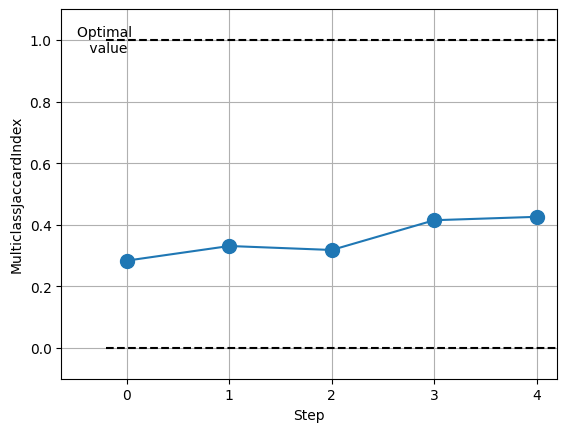

In [5]:
from accelerate import notebook_launcher

notebook_launcher(train, num_processes=1, mixed_precision="fp16")

# Model outputs

Next we will visualize what kind of outputs the model is able to produce after 5 epochs of training. 

Especially, we will look at the `hovernet`, `type` and the `inst` maps.

- The `inst` maps are used as the object (nuclei) masks that determine whether the model detects objects as nuclei or not.
- The `hovernet` maps on the other hand are used as the input for `hovernet`-post-processing pipeline that is used to separate clumped and overlapping nuclei from each other to produce an instance segmentation map. 
- The `type` maps are used to classify the nuclei instances into the `pannuke` cell type classes. Note that the type maps are also post-processed with a majority-voting approach in the post-processing pipeline since typically there is a mixture of different classes within a predicted nuclei as you will see from the type maps below. 

In [6]:
from accelerate import load_checkpoint_and_dispatch


# The model state dict was saved in the project_dir
model = cellvit_sam_base(
    enc_name="samvit_base_patch16",
    pretrained=False,
    type_classes=len(pannuke_module.type_classes),
)

model = load_checkpoint_and_dispatch(
    model,
    checkpoint=(
        Path.home() / "pannuke/cellvit_accelerate/model.safetensors"
    ).as_posix(),
)

(512, 512, 256, 128) [{'module': 'blocks.0', 'num_chs': 768, 'reduction': 16}, {'module': 'blocks.1', 'num_chs': 768, 'reduction': 16}, {'module': 'blocks.2', 'num_chs': 768, 'reduction': 16}, {'module': 'blocks.3', 'num_chs': 768, 'reduction': 16}]


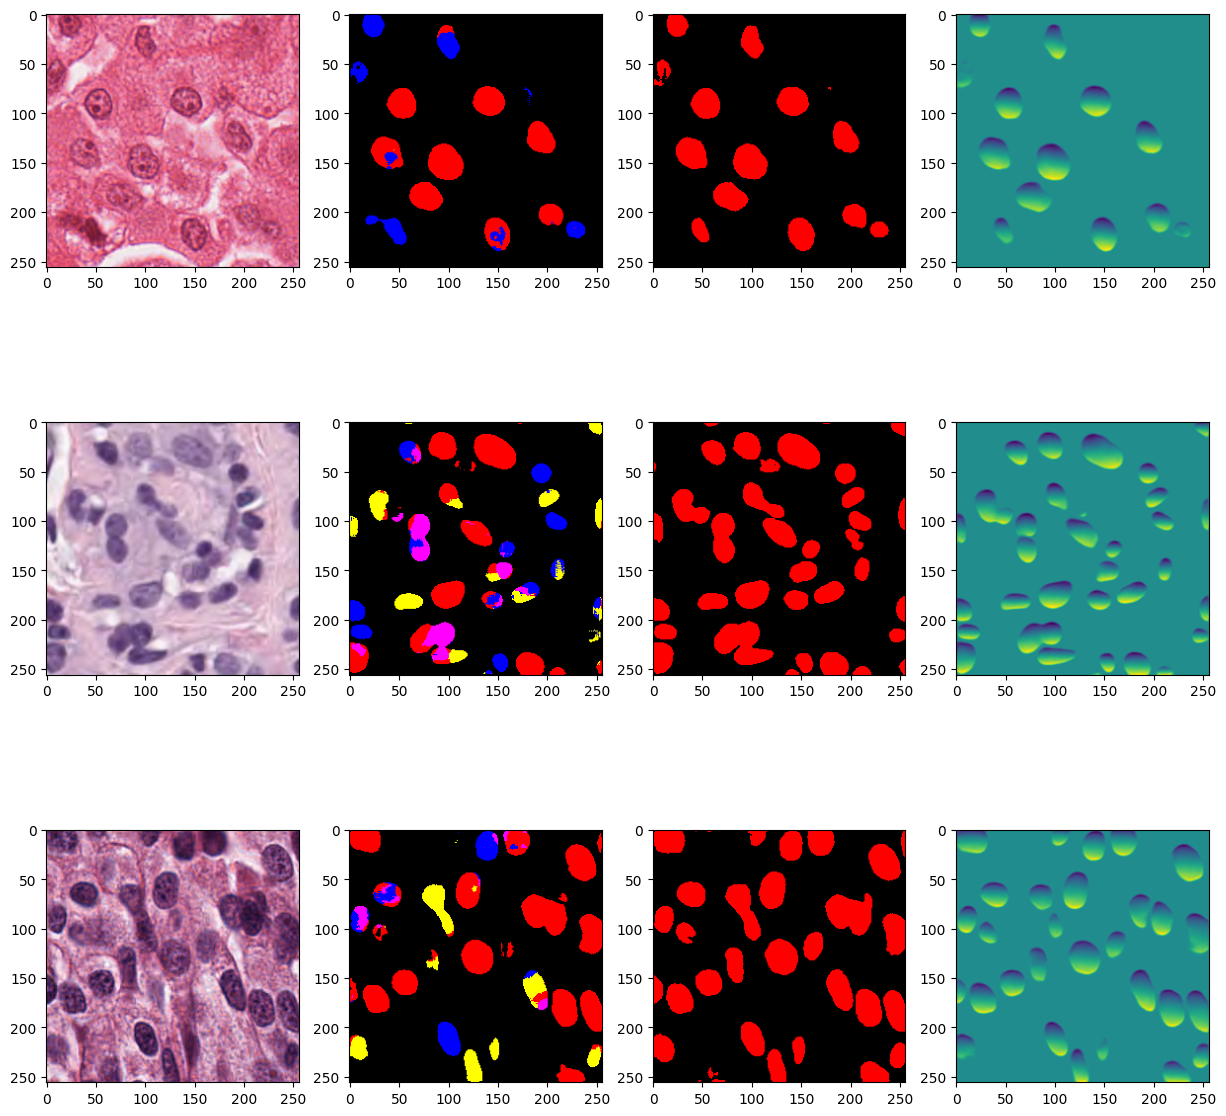

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from cellseg_models_pytorch.utils import minmax_normalize, FileHandler

img_dir = save_dir / "valid" / "images"
mask_dir = save_dir / "valid" / "labels"
imgs = sorted(img_dir.glob("*"))
masks = sorted(mask_dir.glob("*"))

ixs = np.random.randint(0, 500, 3)
im1 = FileHandler.read_img(imgs[ixs[0]])
im2 = FileHandler.read_img(imgs[ixs[1]])
im3 = FileHandler.read_img(imgs[ixs[2]])
img1 = torch.from_numpy(minmax_normalize(im1)).permute(2, 0, 1).unsqueeze(0).float()
img2 = torch.from_numpy(minmax_normalize(im2)).permute(2, 0, 1).unsqueeze(0).float()
img3 = torch.from_numpy(minmax_normalize(im3)).permute(2, 0, 1).unsqueeze(0).float()

pred1 = model(img1)
pred2 = model(img2)
pred3 = model(img3)

fig, ax = plt.subplots(3, 4, figsize=(15, 15))
ax = ax.flatten()
ax[0].imshow(im1)
ax[1].imshow(
    label2rgb(np.argmax(pred1["type"].squeeze().detach().numpy(), axis=0), bg_label=0)
)
ax[2].imshow(
    label2rgb(np.argmax(pred1["inst"].squeeze().detach().numpy(), axis=0), bg_label=0)
)
ax[3].imshow(pred1["hovernet"].squeeze().detach().numpy()[0])
ax[4].imshow(im2)
ax[5].imshow(
    label2rgb(np.argmax(pred2["type"].squeeze().detach().numpy(), axis=0), bg_label=0)
)
ax[6].imshow(
    label2rgb(np.argmax(pred2["inst"].squeeze().detach().numpy(), axis=0), bg_label=0)
)
ax[7].imshow(pred2["hovernet"].squeeze().detach().numpy()[0])
ax[8].imshow(im3)
ax[9].imshow(
    label2rgb(np.argmax(pred3["type"].squeeze().detach().numpy(), axis=0), bg_label=0)
)
ax[10].imshow(
    label2rgb(np.argmax(pred3["inst"].squeeze().detach().numpy(), axis=0), bg_label=0)
)
ax[11].imshow(pred3["hovernet"].squeeze().detach().numpy()[0])
plt.show()

Typically, encoder-decoder based nuclei segmentation model outputs require post-processing. The main-task of the post-processing is to separate clumped nuclear-objects which is a renowned problem in nuclei segmentation. With `cellseg_models.pytorch`, inference and post-processing can be executed with specific `Inferer` classes that can be found in the `cellseg_models_pytorch.inference` module. 

Since the Pannuke-dataset has only 256x256px images, we can use the `ResizeInferer` to run the inference and post-processing (without actually resizing the images). The `Inferer`s take in an input directory and a set of arguments, from which, the `instance_postproc` is the most important since it sets the post-processing method to be used. Here, we will use `hovernet` post-processing.

Other important params include: 
- `out_activations` - Sets the output activation functions for each of the model outputs
- `out_boundary_weights` - Sets whether we will use a weight matrix to add less weight to boundaries of the predictions. This can only be useful when inference is run for bigger images that are patched in overlapping patches (inference with overlapping patches can be done with the `SlidingWindowInferer`).
- `normalization` - Should be set to the same one as during training.
- `n_images` - Run inference only for the 50 first images of inside the input folder.

In [9]:
from cellseg_models_pytorch.inference import ResizeInferer

inferer = ResizeInferer(
    model=model,
    input_path=save_dir / "valid" / "images",
    out_activations={"hovernet": None, "inst": "sigmoid", "type": "softmax"},
    out_boundary_weights={"hovernet": False, "inst": False, "type": False},
    resize=(256, 256),  # Not actually resizing anything,
    instance_postproc="hovernet",
    batch_size=8,
    n_images=50,  # Use only the 50 first images of the folder
    normalization="minmax",
)
inferer.infer()

Running inference: 100%|██████████| 7/7 [00:02<00:00,  2.64batch/s, post-processing]


**Let's plot some results**

With only 5 epochs of training, we can get moderate results by just eyeballing. 

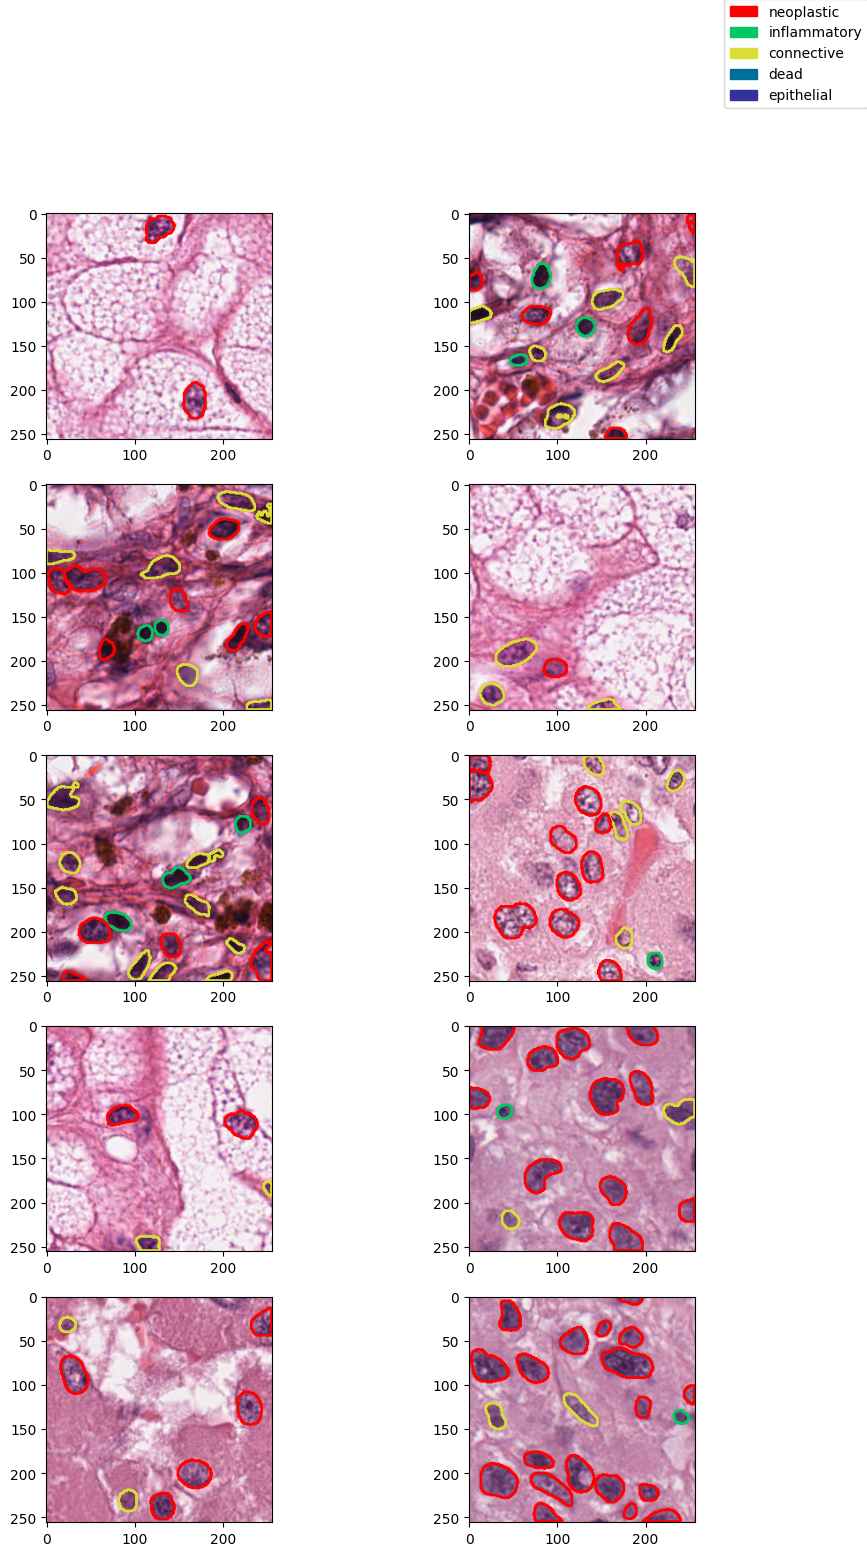

In [10]:
import numpy as np
from cellseg_models_pytorch.utils import draw_thing_contours
import matplotlib.patches as mpatches


fig, ax = plt.subplots(5, 2, figsize=(10, 17))
ax = ax.flatten()
ixs = np.random.choice(50, 10, replace=False)

samples = list(inferer.out_masks.keys())
for i, ix in enumerate(ixs):
    masks = inferer.out_masks[samples[ix]]

    img_path = save_dir / "valid" / f"images/{samples[ix]}.png"
    img = FileHandler.read_img(img_path)
    cont = draw_thing_contours(masks["inst"], img, masks["type"])
    ax[i].imshow(cont)

# add legend
cmap = {
    1: (255.0 / 255, 0.0, 0.0),
    2: (0.0, 200.0 / 255, 100.0 / 255),
    3: (220.0 / 255, 220.0 / 255, 55.0 / 255),
    4: (0.0, 110.0 / 255, 155.0 / 255),
    5: (50.0 / 255, 50.0 / 255, 155.0 / 255),
}
labels = {k: j for j, k in pannuke_module.type_classes.items()}
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
fig.legend(handles=patches, loc=1, borderaxespad=0)